# Part 1 | Augmented Reality

## Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from util.loadVid  import loadVid

In [2]:
import sys
sys.path.append('..')
from common import *

## Constants

In [3]:
OUT = 'out'
if not os.path.exists(OUT):
    os.makedirs(OUT)
    
IN = 'assets'

## Reading the cover image

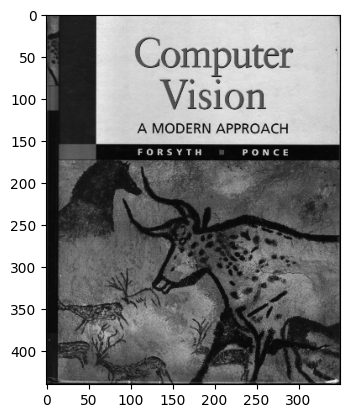

In [4]:
cover = cv2.imread(IN + '/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(cover, cmap='gray')

## Reading the videos

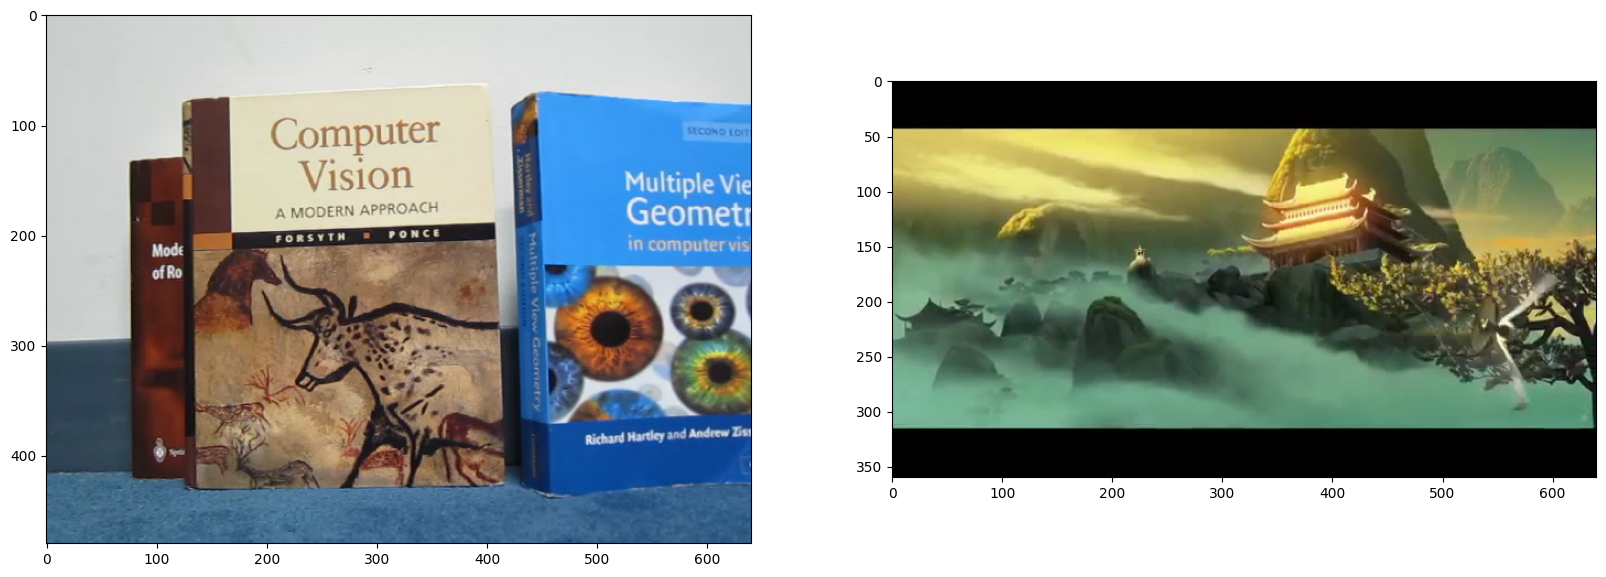

In [5]:
# book_frames = loadVid('assets/book.mov')
# trailer_frames = loadVid(IN + '/ar_source.mov')

# save the captured videos to save time

# np.save(OUT + '/book_frames.npy', book_frames)
# np.save(OUT + '/trailer_frames.npy', trailer_frames)

# load the saved videos

book_frames = np.load(OUT + '/book_frames.npy')
trailer_frames = np.load(OUT + '/trailer_frames.npy')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(book_frames[0,:,:,::-1])
axes[1].imshow(trailer_frames[0,:,:,::-1])	

## Get dimensions

In [6]:
# book video dimensions
book_h, book_w = book_frames[0].shape[:2]

# trailer video dimensions
trailer_h, trailer_w = trailer_frames[0].shape[:2]

# Cover image dimensions
cover_h, cover_w = cover.shape[:2]

## Calculating the homography matrix

### For the first frame

In [7]:
book_gray = cv2.cvtColor(book_frames[0], cv2.COLOR_BGR2GRAY)

# Calculate descriptors (feature vectors)
kp_cover, des_cover = get_image_sift_feature(cover)
kp_book, des_book = get_image_sift_feature(book_gray)

# Match the features
matches = get_matches(des_cover, des_book)


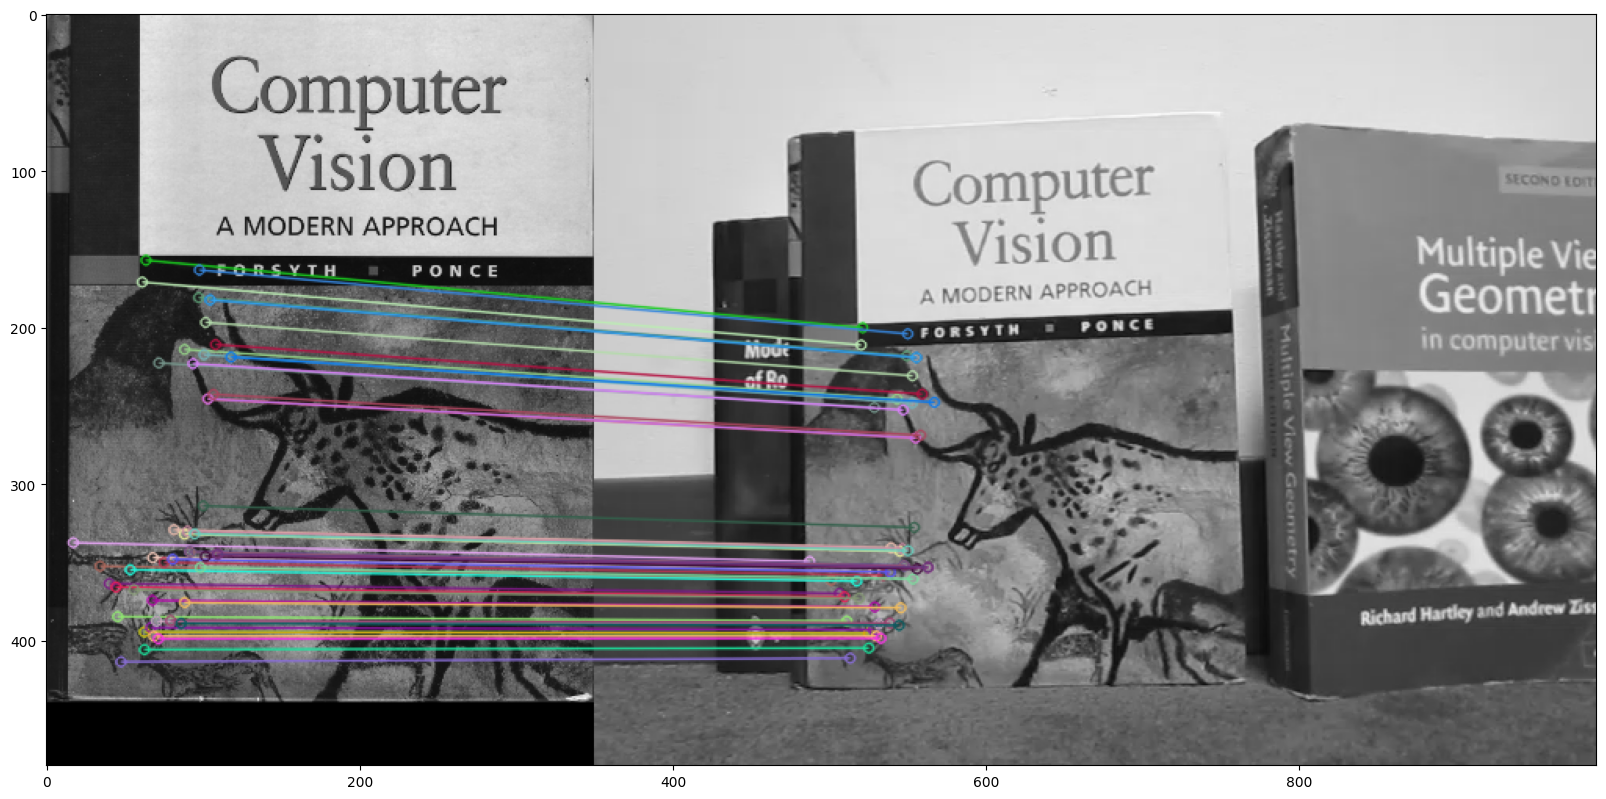

In [11]:
# draw first 50 matches
matched_img = cv2.drawMatchesKnn(cover, kp_cover, book_gray, kp_book, matches[:50], book_gray, flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(matched_img)
plt.show()

In [54]:
# Get the matched keypoints
pts_cover = get_matched_pt(kp_cover, matches)
pts_book = get_matched_pt(kp_book, matches)

# Find the homography matrix
homography_mat = cv2.findHomography(pts_cover, pts_book)[0]
homography = get_homograph_mat(pts_cover, pts_book)

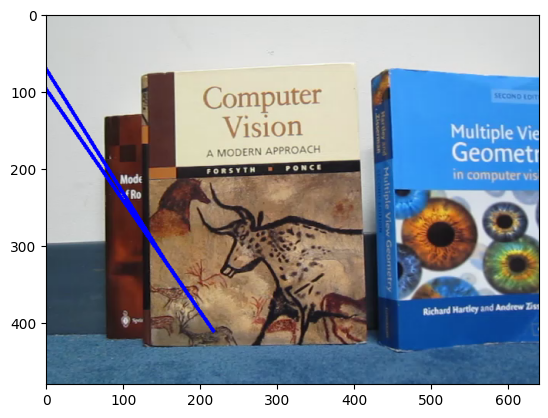

In [76]:
# Get the corners of the cover in the book
corners = np.array([ 
        [0, 0],
        [0, cover_h-1],
        [cover_w-1, cover_h-1],
        [cover_w-1, 0]
    ],
    dtype=np.float32).reshape(-1,1,2)
corners_book = cv2.perspectiveTransform(corners, homography_mat)

# Draw the cover in the book
outline = cv2.polylines(book_frames[0].copy(), [np.int32(corners_book)], True, (255, 0, 0), 3) 

plt.imshow(outline[:,:,::-1])


(480.0, 0.0)

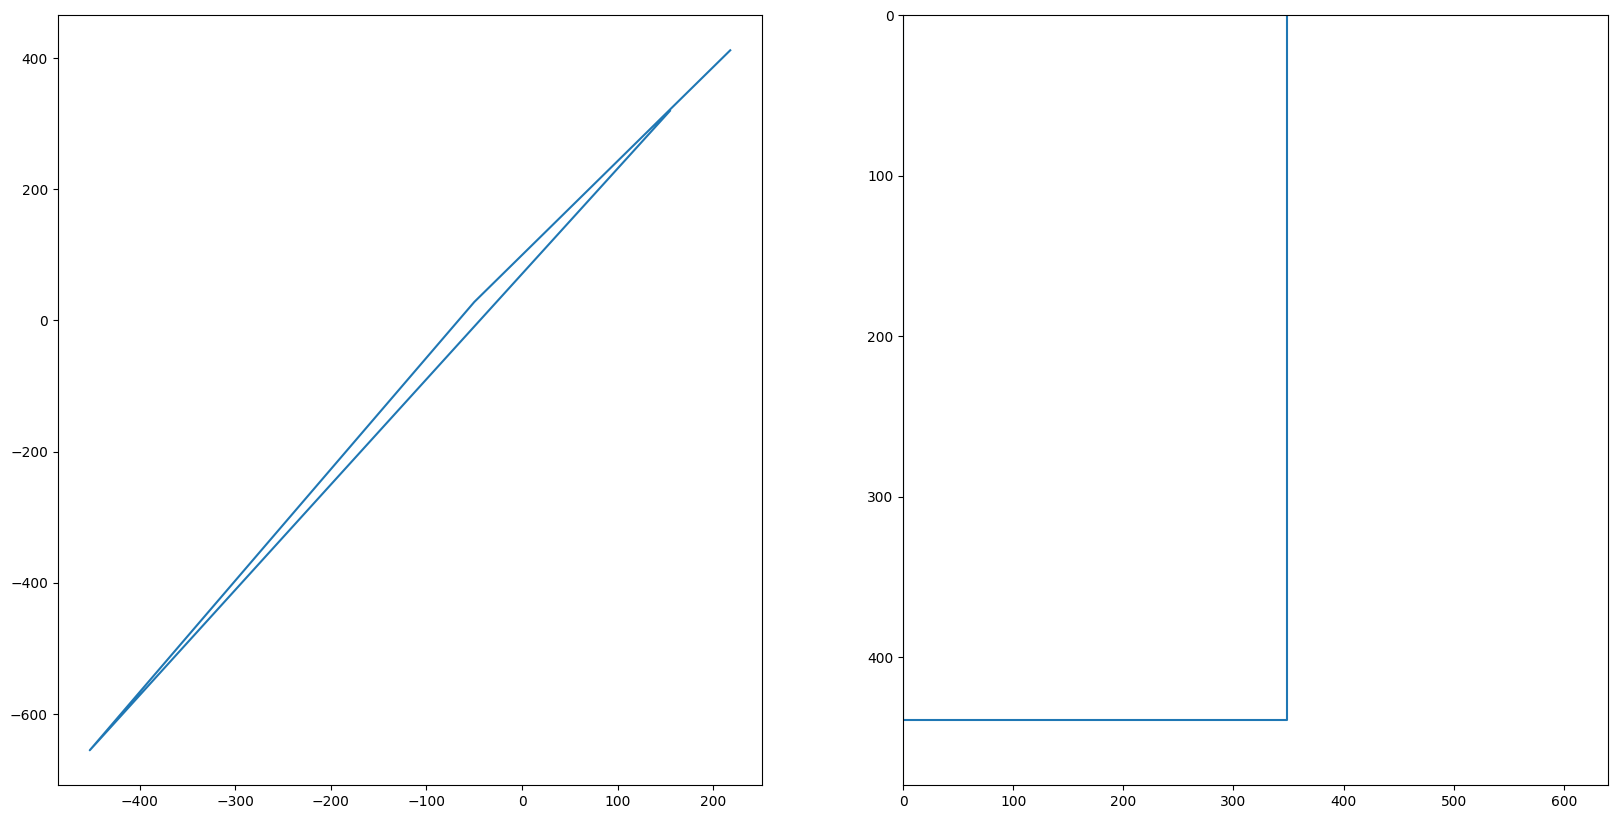

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(corners_book[:,:,0], corners_book[:,:,1])
axes[1].plot(corners[:,:,0], corners[:,:,1])

# axes[0].set_xlim(0, book_w)
# axes[0].set_ylim(book_h, 0)

axes[1].set_xlim(0, book_w)
axes[1].set_ylim(book_h, 0)

In [ ]:

# Warp the cover image to the book image
cover_to_book = cv2.warpPerspective(cover, homography_mat, (book_w, book_h))

# Create a mask of cover image and create its inverse mask also
ret, mask = cv2.threshold(cover_to_book, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# Black-out the area of cover in book image
book_bg = cv2.bitwise_and(book_gray, book_gray, mask=mask_inv)

# Put cover in book image and modify the book image
dst = cv2.add(book_bg, cover_to_book)

#plt.imshow(dst, cmap='gray')